In [1]:
import autograd

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils
import vb_lib.structure_optimization_lib as str_opt_lib

import paragami
import vittles

from copy import deepcopy

import argparse
import distutils.util

import os

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from BNP_modeling import cluster_quantities_lib, modeling_lib
import BNP_modeling.optimization_lib as opt_lib


In [2]:
np.random.seed(53453)

# Draw data

In [3]:
n_obs = 50
n_loci = 40
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

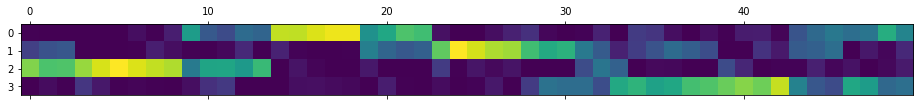

In [5]:
plt.matshow(true_ind_admix_propn.T)

In [6]:
g_obs.shape

(50, 40, 3)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [8]:
k_approx = 4

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
use_logitnormal_sticks = False

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (40, 4, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_beta_params] = NumericArrayPattern (50, 3, 2) (lb=0.0, ub=inf)


## Initialize 

In [11]:
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                use_logitnormal_sticks)

# Optimize

In [12]:
vb_opt_free_params = \
    str_opt_lib.optimize_structure(g_obs, vb_params_dict, vb_params_paragami,
                                prior_params_dict,
                                gh_loc, gh_weights,
                                use_logitnormal_sticks = use_logitnormal_sticks,
                                run_cavi = True,
                                cavi_max_iter = 100,
                                cavi_tol = 1e-2,
                                netwon_max_iter = 20,
                                max_precondition_iter = 25,
                                gtol=1e-8, ftol=1e-8, xtol=1e-8,
                                approximate_preconditioner = True)

vb_opt_dict = vb_params_paragami.fold(vb_opt_free_params, free=True)

running CAVI. 
iteration [0]; kl:3369.100652
iteration [1]; kl:3093.487351
iteration [2]; kl:3042.477997
iteration [3]; kl:3023.308631
iteration [4]; kl:3013.636864
iteration [5]; kl:3007.852735
iteration [6]; kl:3004.006019
iteration [7]; kl:3001.263703
iteration [8]; kl:2999.216139
iteration [9]; kl:2997.638612
iteration [10]; kl:2996.396288
iteration [11]; kl:2995.402195
iteration [12]; kl:2994.596996
iteration [13]; kl:2993.938464
iteration [14]; kl:2993.395585
iteration [15]; kl:2992.945026
iteration [16]; kl:2992.568905
iteration [17]; kl:2992.253308
iteration [18]; kl:2991.987278
iteration [19]; kl:2991.762096
iteration [20]; kl:2991.570759
iteration [21]; kl:2991.407604
iteration [22]; kl:2991.268019
iteration [23]; kl:2991.148224
iteration [24]; kl:2991.045105
iteration [25]; kl:2990.956089
iteration [26]; kl:2990.879035
iteration [27]; kl:2990.812157
iteration [28]; kl:2990.753963
iteration [29]; kl:2990.703197
iteration [30]; kl:2990.658802
iteration [31]; kl:2990.619886
ite

In [13]:
vb_params_dict = deepcopy(vb_opt_dict)

# Check results

In [14]:
if use_logitnormal_sticks: 
    e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                        vb_opt_dict['ind_mix_stick_propn_mean'], 
                        vb_opt_dict['ind_mix_stick_propn_info'],
                        gh_loc, gh_weights)

else: 
    ind_mix_stick_beta_params = vb_opt_dict['ind_mix_stick_beta_params']
    e_stick_lengths = \
            modeling_lib.get_e_beta(ind_mix_stick_beta_params)
    e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

e_pop_freq = modeling_lib.get_e_beta(vb_opt_dict['pop_freq_beta_params'])

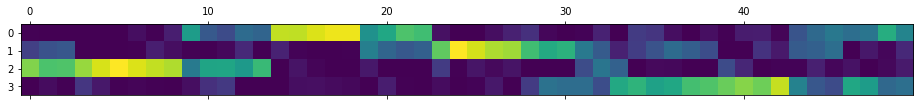

In [15]:
plt.matshow(true_ind_admix_propn.T)

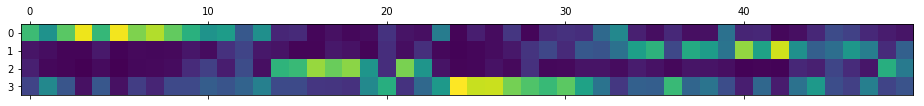

In [16]:
plt.matshow(e_ind_admix.T)